# Chapter: Fault Prognosis: RUL Estimation


# Topic: RUL Estimation for a Wind Turbine

In [1]:
# packages
import numpy as np, matplotlib.pyplot as plt
import scipy.io, scipy.optimize
from scipy.stats import kurtosis, skew

plt.rcParams.update({'font.size': 12})

In [15]:
# function to compute time domain features
def timeDomainFeatures(VibData):
     N = len(VibData)
     vibMean = np.mean(VibData)                                                 
     vibStd = np.std(VibData, ddof=1, axis=0)                                 
     vibRMS = np.sqrt(np.sum(VibData ** 2)/N)
     vibPeak = np.max(np.abs(VibData))
     vibPeak2Peak = np.max(VibData) - np.min(VibData)
     vibSkewness = skew(VibData, axis=0)
     vibKurtosis = kurtosis(VibData, fisher=False)  
     vibShapeFactor = vibRMS / (np.mean(np.abs(VibData)))          
     vibCrestFactor = np.max(np.abs(VibData)) / vibRMS
     vibImpulseFactor = np.max(np.abs(VibData)) / (np.mean(np.abs(VibData)))
     vibMarginFactor = np.max(np.abs(VibData)) / (np.mean(np.sqrt(abs(VibData))) ** 2)

     features = np.array([vibMean, vibStd, vibRMS, vibPeak, vibPeak2Peak, vibSkewness, vibKurtosis, vibShapeFactor, vibCrestFactor, vibImpulseFactor, vibMarginFactor])
     return features

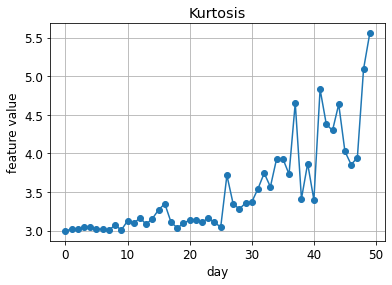

In [4]:
# collect feature values for each day 
import glob
FilenamesList = glob.glob('data-2013*.mat') # fetch names of all relevant files 

Nfeatures = 11
features50days = np.zeros((50, Nfeatures))

for i in range(len(FilenamesList)):
    matlab_data = scipy.io.loadmat(FilenamesList[i], struct_as_record = False) # read data from the file
    vib_data = matlab_data['vibration'][:,0]
    
    features = timeDomainFeatures(vib_data)
    features50days[i,:] = features

# plot kurtosis
plt.figure()
plt.plot(features50days[:,6], '-o')
plt.xlabel('day'), plt.ylabel('feature value')
plt.title('Kurtosis')
plt.grid()
plt.show()

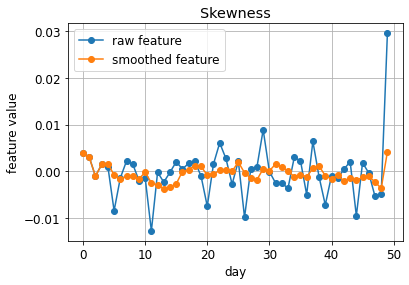

In [8]:
# smooth features using moving average
import pandas as pd

windowSize = 5
features50days_smoothed = pd.DataFrame(features50days).rolling(windowSize).mean().values
features50days_smoothed[:windowSize-1,:] = features50days[:windowSize-1,:]# replace nan in first 4 rows with original values

plt.figure()
plt.plot(features50days[:, 5], '-o', label='raw feature')
plt.plot(features50days_smoothed[:, 5], '-o', label='smoothed feature')
plt.xlabel('day'), plt.ylabel('feature value')
plt.title('Skewness')
plt.legend(), plt.grid()
plt.show()

In [9]:
#  separate training data
Ndays_train = 32 # ~ 2/3rd
features_train = features50days_smoothed[:Ndays_train, :]
features_all = features50days_smoothed

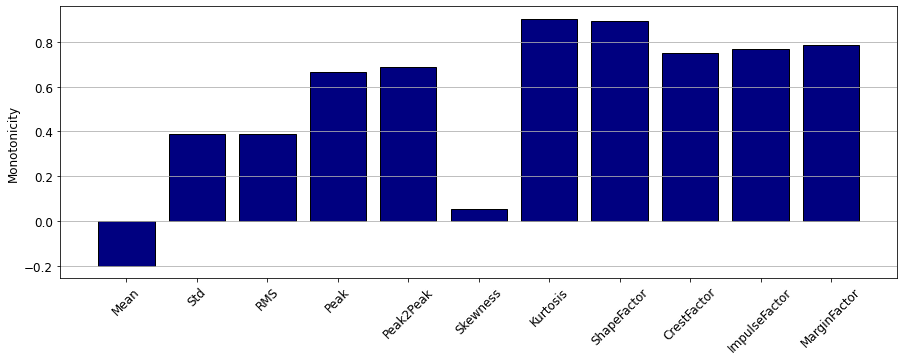

In [10]:
# monotonicity of features
from scipy.stats import spearmanr
feature_monotonicity = np.zeros((Nfeatures,))

for feature in range(Nfeatures):
    result = spearmanr(range(Ndays_train), features_train[:,feature])
    feature_monotonicity[feature] = result.statistic

# bar plot
featureNames = ['Mean', 'Std', 'RMS', 'Peak', 'Peak2Peak', 'Skewness', 'Kurtosis', 'ShapeFactor', 'CrestFactor', 'ImpulseFactor', 'MarginFactor']

plt.figure(figsize=(15,5))
plt.bar(range(Nfeatures), feature_monotonicity, tick_label=featureNames, color='navy', edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel('Monotonicity')
plt.grid(axis='y')
plt.show()

# pick features with monotonicity >= 0.7
featuresSelected = np.where(np.abs(feature_monotonicity) >= 0.7)[0]
selectFeatures_train = features_train[:,featuresSelected]
selectFeatures_all = features_all[:,featuresSelected]

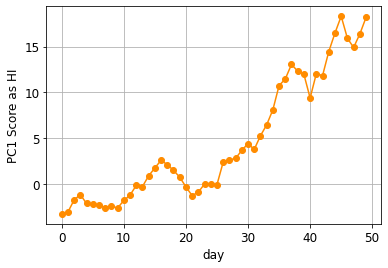

In [11]:
# perform PCA and extract scores along the first principal component
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(selectFeatures_train)
selectFeatures_train_normal = scaler.transform(selectFeatures_train)
selectFeatures_all_normal = scaler.transform(selectFeatures_all)

pca = PCA().fit(selectFeatures_train_normal)
PCA_all_scores = pca.transform(selectFeatures_all_normal)

plt.figure()
plt.plot(PCA_all_scores[:,0],'-o', color='darkorange')
plt.xlabel('day'), plt.ylabel('PC1 Score as HI')
plt.grid()
plt.show()

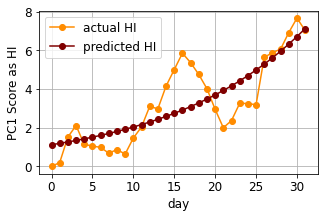

In [12]:
# fit exponential model (HI = aexp(bt) + c); t is in days
PCA_train_scores = pca.transform(selectFeatures_train_normal)
HI_train = PCA_train_scores[:,0]
HI_train = HI_train - HI_train[0]

def func(t, a, b):
    return a*np.exp(b*t)

param_opt, param_cov = scipy.optimize.curve_fit(func, range(32), HI_train)

plt.figure(figsize=(5,3))
plt.plot(range(32), HI_train,'-o', color='darkorange', label='actual HI')
plt.plot(range(32), func(np.arange(32), *param_opt),'-o', color='maroon', label='predicted HI')
plt.xlabel('day'), plt.ylabel('PC1 Score as HI')
plt.legend()
plt.grid()
plt.show()

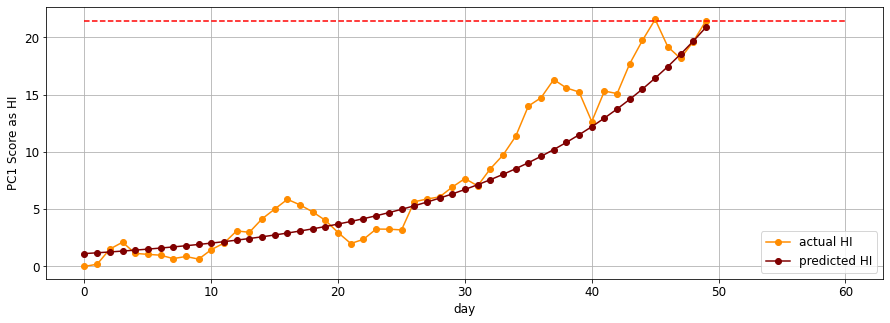

In [13]:
# forecast using the degradation model
HI_all = PCA_all_scores[:,0]
HI_all = HI_all - HI_all[0]

plt.figure(figsize=(15,5))
plt.plot(range(50), HI_all,'-o', color='darkorange', label='actual HI')
plt.plot(range(50), func(np.arange(50), *param_opt),'-o', color='maroon', label='predicted HI')
plt.plot([0,60], [HI_all[-1],HI_all[-1]],'--', color='red')
plt.xlabel('day'), plt.ylabel('PC1 Score as HI')
plt.legend()
plt.grid()
plt.show()